# Summary of DLPET-project 
In this project, the goal is to explore various reconstruction techniques and deep learning methods, with a focus on PET (Positron Emission Tomography). This knowledge will be applied to the virtual Shepp-Logan phantom and other images, aiming to develop a conceptual understanding of these methods and implement them in practice.

### Filtered Back Projection 

Filtered Back Projection (FBP) is one of the simplest reconstruction methods. It takes data from the sinogram space and back-projects it into the image domain. However, back-projection alone smears the data, resulting in a blurry reconstructed image. To counter this, a high-pass filter is applied to remove low frequencies, enhancing image details and improving clarity.

##### Mathematical formula

$$f(x,y) = \frac{1}{2}\mathcal{B}\{\mathcal{F}^{-1}[|S|\mathcal{F}(\mathcal{R}\theta)(S,\theta)] \}(x,y)$$

where $\mathcal{B}$ is the back-projection operator, $\mathcal{F}$ is the fourier transform, |S| is the filter applied and $\mathcal{R}$ is the fowoard operator. 

In [3]:
import odl
import numpy as np
import matplotlib.pyplot as plt

# Define the reconstruction space
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[300, 300], dtype='float32'
)

# Define the angle partition 
angle_partition = odl.uniform_partition(0, np.pi, 1000)

# Define the detector partition
detector_partition = odl.uniform_partition(-30, 30, 500)

# Define a parallel beam geometry 
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Create the foward operator 
ray_trafo = odl.tomo.RayTransform(reco_space,geometry)

# Define the SHepp-Logan phantom  
shepp_logan = odl.phantom.shepp_logan(reco_space,modified = True)
og_data = ray_trafo(shepp_logan.copy())

# Convert the PET data to a NumPy array for manipulation
phantom_array = shepp_logan.asarray().copy()


# Simulate high-uptake regions by modifying intensity values
x, y = np.meshgrid(
    np.linspace(-20, 20, 300), np.linspace(-20, 20, 300)
)
hot_spot = ((x - 5)**2 + (y - 5)**2) < 2**2  # Circle at (5, 5) with radius 5
phantom_array[hot_spot] = phantom_array.max() * 0.8  # 0.8 the max intensity
phantom_array *= 0.7 # Scaling the overall intensity of the phantom

# Convert back to an ODL element
modified_phantom = reco_space.element(phantom_array)

# Convert to data space 
pet_data = ray_trafo(modified_phantom)
pet_data = odl.phantom.poisson_noise(pet_data)* 1.0


# --- Create the Filter --- #
# Fourier transform in detector direction
fourier = odl.trafos.FourierTransform(ray_trafo.range, axes=[1])

# Create ramp in the detector direction
ramp_function = fourier.range.element(lambda x: np.abs(x[1]) / (2 * np.pi))

# Create ramp filter via the convolution formula with fourier transforms
ramp_filter = fourier.inverse * ramp_function * fourier

# Create filtered back-projection by composing the back-projection (adjoint)
# with the ramp filter.
fbp = ray_trafo.adjoint * ramp_filter

# --- Implement the filter --- #
# Calculate filtered back-projection of PET data and original data
fbp_pet = fbp(pet_data)
fbp_original = fbp(og_data)

# Try only backprojection for the PET data and original data
bp_pet = ray_trafo.adjoint(pet_data)
bp_orginal = ray_trafo.adjoint(og_data)


# Display results form the original Shepp-Logan phantom 
#shepp_logan.show(title='Original Phantom (Shepp-Logan)')
#og_data.show(title = 'Original Phantom Data')
#bp_orginal.show(title = 'Back-Projection of the Original Phantom Data')
#fbp_original.show(title = 'Reconstructed Original Image with FBP')

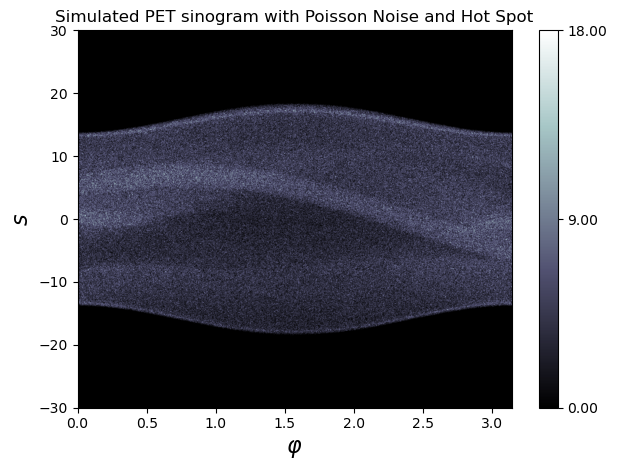

<Figure size 640x480 with 0 Axes>

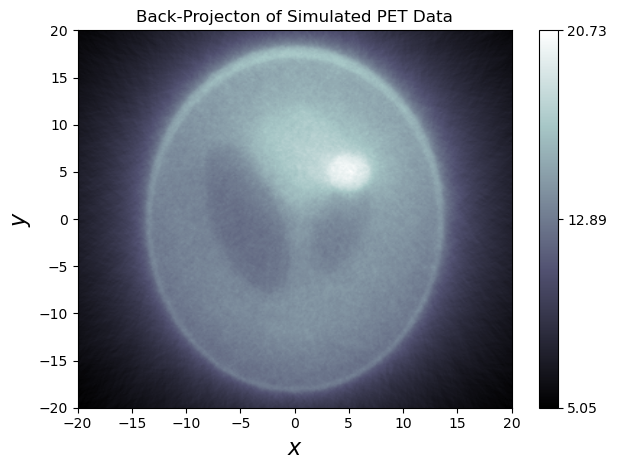

<Figure size 640x480 with 0 Axes>

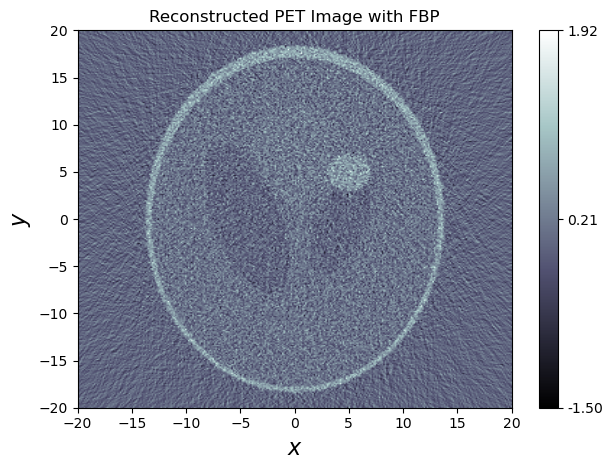

<Figure size 640x480 with 0 Axes>

In [2]:
# Display the results from the simulated PET phantom
pet_data.show(title='Simulated PET sinogram with Poisson Noise and Hot Spot')
bp_pet.show(title='Back-Projecton of Simulated PET Data')
fbp_pet.show(title='Reconstructed PET Image with FBP')
plt.show()